In [ ]:
for i in np.array(range(1010))/1000.:
    y_pred = pd.DataFrame([0 if y_preds[j][0] > i else 1 for j in range(len(y_preds))])
    print(round(sklearn.metrics.accuracy_score(y_pred = y_pred, y_true = y_test),3), str(i*100) + "% is the threshold" )

In [1]:
import pandas as pd
import numpy as np
import tqdm

In [2]:
# importing necessary libraries
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import svm, linear_model, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import itertools
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier 

/Users/elutins/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/elutins/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [4]:
pd.options.display.max_columns = 999

# reading in dataframe
df = pd.read_csv('../CapStone/LetsModelBaby.csv')

#dropping unecessary column
df.drop('Unnamed: 0', axis=1, inplace=True)

# properly formatting date column
df['Date'] = pd.to_datetime(df['Date'])

/Users/elutins/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(12878, 96)

In [7]:
df.head()

,Date,Pitcher1,Pitcher_Team1,Pitcher1_BB%,Pither1_CG,Pitcher1_ERA,Pitcher1_HR/9,Pitcher1_K%,Pitcher1_ShO,Pitcher1_WHIP,BattingTeam1_RBIs/Game,BattingTeam1,BattingTeam1_AVG,BattingTeam1_BABIP,BattingTeam1_BB%,BattingTeam1_K%,BattingTeam1_OBP,BattingTeam1_SLG,Pitcher2,Pitcher_Team2,Pitcher2_BB%,Pither2_CG,Pitcher2_ERA,Pitcher2_HR/9,Pitcher2_K%,Pitcher2_ShO,Pitcher2_WHIP,BattingTeam2_RBIs/Game,BattingTeam2,BattingTeam2_AVG,BattingTeam2_BABIP,BattingTeam2_BB%,BattingTeam2_K%,BattingTeam2_OBP,BattingTeam2_SLG,Line,Opponent_y,Over/Under,Score,Game Line,O/U,O/U Game Result,Total Runs in Game,Win/Loss Game,Actual Away Starter,Actual Home Starter,Bullpen_Team1,Bullpen1_K%,Bullpen1_BB%,Bullpen1_WHIP,Bullpen1_HR/9,Bullpen1_ERA,Bullpen_Team2,Bullpen2_K%,Bullpen2_BB%,Bullpen2_WHIP,Bullpen2_HR/9,Bullpen2_ERA,Over hit?,Combined_SP_BB%,Combined_SP_ERA,Combined_SP_HR/9,Combined_SP_K%,Combined_SP_WHIP,Combined_RBIs/Game,Combined_Bat_AVG,Combined_Bat_BABIP,Combined_Bat_BB%,Combined_Bat_K%,Combined_Bat_OBP,Combined_bat_slg,Combined_bullpen_k%,combined_bp_bb%,combnied_bp_WHIP,combined_bp_HR/9,combined_bp_ERA,Winners,Home_Team_Win?,diff_SP_BB%,diff_SP_ERA,diff_SP_HR/9,diff_SP_K%,diff_SP_WHIP,diff_RBIs/Game,diff_Bat_AVG,diff_Bat_BABIP,diff_Bat_BB%,diff_Bat_K%,diff_Bat_OBP,diff_bat_slg,diff_bullpen_k%,diff_bp_bb%,diff_bp_WHIP,diff_bp_HR/9,diff_bp_ERA
0,2016-05-19,Mike Foltynewicz,ATL,0.026316,0.0,2.967033,1.978022,0.210526,0,1.208791,4.692308,PIT,0.279680,0.334300,0.095481,0.197327,0.358793,0.430444,Jeff Locke,PIT,0.122093,0.0,5.549598,1.206434,0.145349,0,1.689008,3.076923,ATL,0.235913,0.297324,0.074848,0.214430,0.298976,0.317055,L 162,PIT,O 8 -104,L 2-8,162,8,O,10.0,L,Mike Foltynewicz,Jeff Locke,ATL,0.243243,0.109797,1.588933,0.996047,4.980237,PIT,0.185059,0.108659,1.520062,1.180556,4.583333,1,0.148409,8.516631,3.184456,0.355875,2.897799,7.769231,0.515592,0.631624,0.170329,0.411757,0.657769,0.747499,0.428303,0.218456,3.108995,2.176603,9.563570,PIT,1,0.095777,2.582565,-0.771588,-0.065177,0.480217,1.615385,0.043767,0.036975,0.020632,-0.017104,0.059817,0.113389,-0.058184,-0.001139,-0.068871,0.184508,-0.396904
1,2016-07-10,Mike Foltynewicz,ATL,0.061453,0.0,4.433498,2.438424,0.195531,0,1.354680,4.011494,CHW,0.251183,0.299223,0.080254,0.214416,0.317504,0.402975,James Shields,CHW,0.102381,0.0,5.784314,1.568627,0.173810,0,1.677560,3.261364,ATL,0.237131,0.287892,0.073069,0.204295,0.300362,0.347725,W 146,CHW,U 9.5 101,W 2-0,146,9.5,U,2.0,W,Mike Foltynewicz,James Shields,ATL,0.228507,0.111614,1.525952,0.840830,4.391003,CHW,0.214349,0.110717,1.513426,0.549227,3.624898,0,0.163833,10.217811,4.007051,0.369340,3.032240,7.272858,0.488314,0.587115,0.153323,0.418710,0.617866,0.750700,0.442856,0.222331,3.039377,1.390057,8.015902,ATL,0,0.040928,1.350816,-0.869796,-0.021721,0.322880,0.750131,0.014053,0.011331,0.007185,0.010121,0.017142,0.055250,-0.014158,-0.000896,-0.012526,-0.291603,-0.766105
2,2016-07-21,Mike Foltynewicz,ATL,0.056522,0.0,3.791209,1.813187,0.217391,0,1.208791,4.851064,COL,0.270429,0.320303,0.081418,0.212130,0.333427,0.452667,Chad Bettis,COL,0.057971,0.0,5.721063,1.195446,0.175983,0,1.537002,3.200000,ATL,0.237377,0.286578,0.073582,0.202213,0.300615,0.349446,W -155,ATL,U 12 -118,W 7-3,-155,12,U,10.0,W,Mike Foltynewicz,Chad Bettis,ATL,0.225511,0.109937,1.531764,0.841664,4.353434,COL,0.201637,0.080357,1.478232,1.214985,5.133311,0,0.114493,9.512271,3.008633,0.393375,2.745793,8.051064,0.507805,0.606881,0.155000,0.414343,0.634042,0.802113,0.427148,0.190294,3.009995,2.056649,9.486745,COL,1,0.001449,1.929854,-0.617741,-0.041408,0.328211,1.651064,0.033052,0.033725,0.007836,0.009917,0.032811,0.103221,-0.023874,-0.029579,-0.053532,0.373321,0.779876
3,2016-07-27,Mike Foltynewicz,ATL,0.070588,0.0,3.913043,1.806020,0.215686,0,1.254181,4.161616,MIN,0.250220,0.298345,0.080981,0.223424,0.315413,0.412628,Tyler Duffey,MIN,0.056122,0.0,5.908558,1.582649,0.178571,0,1.512309,3.170000,ATL,0.237089,0.286372,0.074757,0.201632,0.301118,0.349472,W 146,MIN,O 8.5 112,W 9-7,146,8.5,O

In [9]:
## CHECKING THE BASELINE SCORE OF HOW MANY TIMES HOME TEAM WINS GAME
df.loc[df['Home_Team_Win?'] == 1].shape

(6754, 95)

#### Baseline score for the home team winning is 52%

In [92]:
## Function for Printing a Confusion Matrix, will be utilized throughout my models. 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# # Compute confusion matrix
# cnf_matrix = confusion_matrix(y_test, y_pred)
# np.set_printoptions(precision=2)

# # Plot non-normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names,
#                       title='Confusion matrix, without normalization')

# # Plot normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')

# plt.show()

# Modeling The Home Team's Winning Probabilities 

## Feature Engineering

In [110]:
# Making new columns for the difference btwn Home - Away Team stats for each pitching and batting stat.
# I have since saved the dataframe which is why this section is commented out

# df['diff_SP_BB%'] = df['Pitcher2_BB%'] -  df['Pitcher1_BB%']
# df['diff_SP_ERA'] = df['Pitcher2_ERA'] - df['Pitcher1_ERA']
# df['diff_SP_HR/9'] = df['Pitcher2_HR/9'] - df['Pitcher1_HR/9']
# df['diff_SP_K%'] = df['Pitcher2_K%'] - df['Pitcher1_K%']
# df['diff_SP_WHIP'] = df['Pitcher2_WHIP'] - df['Pitcher1_WHIP']
# df['diff_RBIs/Game'] = df['BattingTeam1_RBIs/Game'] - df['BattingTeam2_RBIs/Game']
# df['diff_Bat_AVG'] = df['BattingTeam1_AVG'] - df['BattingTeam2_AVG']
# df['diff_Bat_BABIP'] = df['BattingTeam1_BABIP'] - df['BattingTeam2_BABIP']
# df['diff_Bat_BB%'] = df['BattingTeam1_BB%'] - df['BattingTeam2_BB%']
# df['diff_Bat_K%'] = df['BattingTeam1_K%'] - df['BattingTeam2_K%']
# df['diff_Bat_OBP'] = df['BattingTeam1_OBP'] - df['BattingTeam2_OBP']
# df['diff_bat_slg'] = df['BattingTeam1_SLG'] - df['BattingTeam2_SLG']
# df['diff_bullpen_k%'] = df['Bullpen2_K%'] - df['Bullpen1_K%']
# df['diff_bp_bb%'] = df['Bullpen2_BB%'] - df['Bullpen1_BB%']
# df['diff_bp_WHIP'] = df['Bullpen2_WHIP'] - df['Bullpen1_WHIP']
# df['diff_bp_HR/9'] = df['Bullpen2_HR/9']- df['Bullpen1_HR/9']
# df['diff_bp_ERA'] = df['Bullpen2_ERA'] - df['Bullpen1_ERA']

In [10]:
# ESTABLISHING THE X AND Y FOR THE Over/Under MODEL. X WILL INCLUDE ALL STATISTICS FROM BOTH BATTING TEAMS.
# CHOOSING NOT TO INCLUDE THE COMBINATION STATS. ONLY USING THOSE STATISTICS TO PREDICT OVER/UNDER

X = df.drop(['Date', 'Pitcher1_ShO', 'Pitcher2_ShO', 'Pither1_CG', 'Pither2_CG','Pitcher1','Pitcher_Team1', 'Pitcher_Team2', 'BattingTeam1', 'BattingTeam2', 'Pitcher2',
        'Pitcher_Team2', 'BattingTeam2', 'Line', 'Opponent_y', 'Over/Under', 'Score', 'Game Line', 'O/U', 'O/U Game Result',
        'Total Runs in Game', 'Win/Loss Game', 'Actual Away Starter', 'Actual Home Starter', 'Bullpen_Team1', 'Bullpen_Team2', 'Over hit?',
            'Winners', 'Home_Team_Win?', 'Combined_SP_BB%', 'Combined_SP_ERA', 'Combined_SP_HR/9', 'Combined_SP_K%','Combined_SP_WHIP','Combined_RBIs/Game',
             'Combined_Bat_AVG','Combined_Bat_BABIP','Combined_Bat_BB%','Combined_Bat_K%','Combined_Bat_OBP','Combined_bat_slg',
             'Combined_bullpen_k%','combined_bp_bb%','combined_bp_HR/9','combined_bp_ERA'], axis=1)

y = df['Home_Team_Win?']

In [11]:
# splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =.33, stratify=y)

## Logistic Regression

In [12]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [13]:
# NORMALIZING FEATURES FOR LOGISTIC REGRESSION 
X_norm = preprocessing.normalize(X)

In [14]:
model = LogisticRegression()

score = cross_val_score(model, X_norm, y, scoring='accuracy')

print score.mean()
print score

0.549386155183
[ 0.55193293  0.54566636  0.55055918]


In [15]:
### Grid Searching Logistic Regression
model = LogisticRegression()

# setting parameters to grid search
penalty = ['l1', 'l2']
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]



grid = GridSearchCV(estimator=model, verbose=1, cv=5, scoring='accuracy', param_grid=dict(penalty=penalty,
                                                                              C=C))
                                                                            


grid.fit(X_norm,y)

print grid.best_score_
print grid.best_params_

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:  1.2min finished


0.558005901538
{'penalty': 'l1', 'C': 10}


In [16]:
# NORMALIZING TRAINING SET TO MAKE PREDICTIONS
Xtrain_norm = preprocessing.normalize(X_train)

In [18]:
model = LogisticRegression(penalty='l1', C=10.0)

model.fit(Xtrain_norm, y_train)

y_preds = model.predict_proba(X_test)
y_preds_2 = model.predict(X_test)

In [19]:
# TESTING ACCURACY SCORE OF LOGISTIC REGRESSION
accuracy_score(y_test, y_preds_2)

0.54517647058823526

In [ ]:
class_names = y.unique()
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_preds_2)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [174]:
print y_preds[0:5]
print y_preds_2[0:5] ## first column of y_preds = 0; second column of y_preds = 1

[[ 0.51  0.49]
 [ 0.48  0.52]
 [ 0.49  0.51]
 [ 0.49  0.51]
 [ 0.4   0.6 ]]
[0 1 1 1 1]


In [184]:
# CODE SHOWING THE ACCURACY SCORE OF MODEL AT EACH THRESHOLD. (H/T MATT BREMS) 
for i in np.array(range(1010))/1000.:
    y_pred = pd.DataFrame([0 if y_preds[j][0] > i else 1 for j in range(len(y_preds))])
    print(round(sklearn.metrics.accuracy_score(y_pred = y_pred, y_true = y_test),3), str(i*100) + "% is the threshold" )

(0.476, '0.0% is the threshold')
(0.476, '0.1% is the threshold')
(0.476, '0.2% is the threshold')
(0.476, '0.3% is the threshold')
(0.476, '0.4% is the threshold')
(0.476, '0.5% is the threshold')
(0.476, '0.6% is the threshold')
(0.476, '0.7% is the threshold')
(0.476, '0.8% is the threshold')
(0.476, '0.9% is the threshold')
(0.476, '1.0% is the threshold')
(0.476, '1.1% is the threshold')
(0.476, '1.2% is the threshold')
(0.476, '1.3% is the threshold')
(0.476, '1.4% is the threshold')
(0.476, '1.5% is the threshold')
(0.476, '1.6% is the threshold')
(0.476, '1.7% is the threshold')
(0.476, '1.8% is the threshold')
(0.476, '1.9% is the threshold')
(0.476, '2.0% is the threshold')
(0.476, '2.1% is the threshold')
(0.476, '2.2% is the threshold')
(0.476, '2.3% is the threshold')
(0.476, '2.4% is the threshold')
(0.476, '2.5% is the threshold')
(0.476, '2.6% is the threshold')
(0.476, '2.7% is the threshold')
(0.476, '2.8% is the threshold')
(0.476, '2.9% is the threshold')
(0.476, '3

(0.477, '28.5% is the threshold')
(0.477, '28.6% is the threshold')
(0.477, '28.7% is the threshold')
(0.477, '28.8% is the threshold')
(0.476, '28.9% is the threshold')
(0.476, '29.0% is the threshold')
(0.476, '29.1% is the threshold')
(0.476, '29.2% is the threshold')
(0.476, '29.3% is the threshold')
(0.476, '29.4% is the threshold')
(0.476, '29.5% is the threshold')
(0.476, '29.6% is the threshold')
(0.476, '29.7% is the threshold')
(0.476, '29.8% is the threshold')
(0.476, '29.9% is the threshold')
(0.476, '30.0% is the threshold')
(0.476, '30.1% is the threshold')
(0.476, '30.2% is the threshold')
(0.476, '30.3% is the threshold')
(0.476, '30.4% is the threshold')
(0.476, '30.5% is the threshold')
(0.476, '30.6% is the threshold')
(0.476, '30.7% is the threshold')
(0.476, '30.8% is the threshold')
(0.476, '30.9% is the threshold')
(0.476, '31.0% is the threshold')
(0.476, '31.1% is the threshold')
(0.476, '31.2% is the threshold')
(0.476, '31.3% is the threshold')
(0.476, '31.4%

(0.544, '55.1% is the threshold')
(0.544, '55.2% is the threshold')
(0.544, '55.3% is the threshold')
(0.545, '55.4% is the threshold')
(0.544, '55.5% is the threshold')
(0.545, '55.6% is the threshold')
(0.546, '55.7% is the threshold')
(0.545, '55.8% is the threshold')
(0.545, '55.9% is the threshold')
(0.544, '56.0% is the threshold')
(0.544, '56.1% is the threshold')
(0.543, '56.2% is the threshold')
(0.543, '56.3% is the threshold')
(0.543, '56.4% is the threshold')
(0.542, '56.5% is the threshold')
(0.541, '56.6% is the threshold')
(0.541, '56.7% is the threshold')
(0.54, '56.8% is the threshold')
(0.54, '56.9% is the threshold')
(0.541, '57.0% is the threshold')
(0.541, '57.1% is the threshold')
(0.541, '57.2% is the threshold')
(0.541, '57.3% is the threshold')
(0.54, '57.4% is the threshold')
(0.539, '57.5% is the threshold')
(0.538, '57.6% is the threshold')
(0.537, '57.7% is the threshold')
(0.537, '57.8% is the threshold')
(0.536, '57.9% is the threshold')
(0.536, '58.0% is

(0.524, '83.5% is the threshold')
(0.524, '83.6% is the threshold')
(0.524, '83.7% is the threshold')
(0.524, '83.8% is the threshold')
(0.524, '83.9% is the threshold')
(0.524, '84.0% is the threshold')
(0.524, '84.1% is the threshold')
(0.524, '84.2% is the threshold')
(0.524, '84.3% is the threshold')
(0.524, '84.4% is the threshold')
(0.524, '84.5% is the threshold')
(0.524, '84.6% is the threshold')
(0.524, '84.7% is the threshold')
(0.524, '84.8% is the threshold')
(0.524, '84.9% is the threshold')
(0.524, '85.0% is the threshold')
(0.524, '85.1% is the threshold')
(0.524, '85.2% is the threshold')
(0.524, '85.3% is the threshold')
(0.524, '85.4% is the threshold')
(0.524, '85.5% is the threshold')
(0.524, '85.6% is the threshold')
(0.524, '85.7% is the threshold')
(0.524, '85.8% is the threshold')
(0.524, '85.9% is the threshold')
(0.524, '86.0% is the threshold')
(0.524, '86.1% is the threshold')
(0.524, '86.2% is the threshold')
(0.524, '86.3% is the threshold')
(0.524, '86.4%

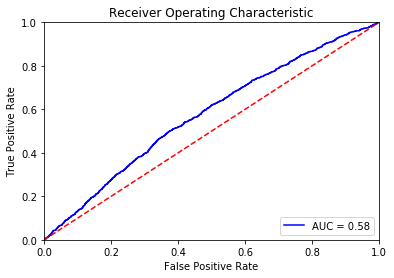

In [186]:
# ROC-AUC CURVE OF THE LOGISTIC REGRESSION MODEL. BECAUSE BASELINE SCORE IS ROUGHLY 50%, MORE CONCERNED WITH ACCURACY
# RATHER THAN ROC-AUC SCORE
fpr, tpr, threshold = roc_curve(y_test, y_preds[:,1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic');
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc);
plt.legend(loc = 'lower right');
plt.plot([0, 1], [0, 1],'r--');
plt.xlim([0, 1]);
plt.ylim([0, 1]);
plt.ylabel('True Positive Rate');
plt.xlabel('False Positive Rate');

## XGBoost Model

In [75]:
# testing classifier with random parameters first
clf = XGBClassifier(n_estimators=20, max_depth=4, gamma=10.0, min_child_weight=0)

clf.fit(X_train, y_train)

y_preds = clf.predict_proba(X_test)

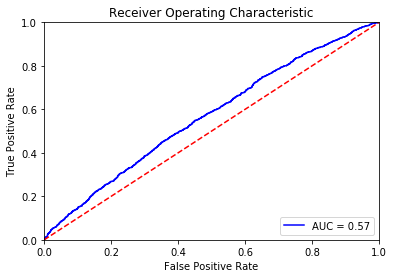

In [76]:
# PRINTING ROC-AUC FOR GIVEN MODEL
fpr, tpr, threshold = roc_curve(y_test, y_preds[:,1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic');
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc);
plt.legend(loc = 'lower right');
plt.plot([0, 1], [0, 1],'r--');
plt.xlim([0, 1]);
plt.ylim([0, 1]);
plt.ylabel('True Positive Rate');
plt.xlabel('False Positive Rate');

In [125]:
## XGBoost Model
model = XGBClassifier()

# setting up xgboost parameters
max_depth = np.arange(9, step=2)
gamma_range = 10.**np.arange(-1, 4)
n_estimators = [4, 8, 12, 16]



# RUNNING GridSearch
grid = GridSearchCV(estimator=model, cv=5, verbose=1, n_jobs=-1, scoring='accuracy', param_grid=dict(max_depth=max_depth, 
                                                                              n_estimators=n_estimators,
                                                                              gamma=gamma_range))
                                                                              

# fitting model
grid.fit(X, y)

print grid.best_score_
print grid.best_params_

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 241 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 491 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 841 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.4min finished


0.550861935083
{'n_estimators': 16, 'max_depth': 4, 'gamma': 10.0, 'min_child_weight': 0}


In [126]:
# testing classifier with random parameters first
clf = XGBClassifier(n_estimators=16, max_depth=4, gamma=10, min_child_weight=0)

clf.fit(X_train, y_train)

y_preds = clf.predict(X_test)

In [127]:
accuracy_score(y_test, y_preds)

0.54447058823529415

Confusion matrix, without normalization
[[ 669 1352]
 [ 542 1687]]
Normalized confusion matrix
[[ 0.33  0.67]
 [ 0.24  0.76]]


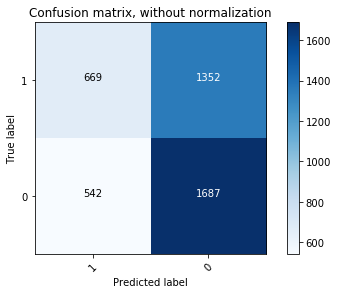

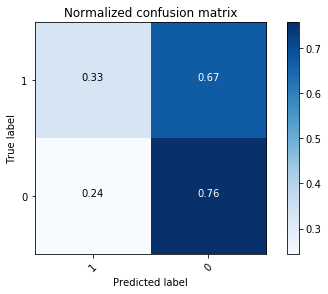

In [100]:
class_names = y.unique()
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Random Forest Model

In [83]:
clf = RandomForestClassifier()

clf.fit(X_train, y_train)

y_preds = clf.predict_proba(X_test)

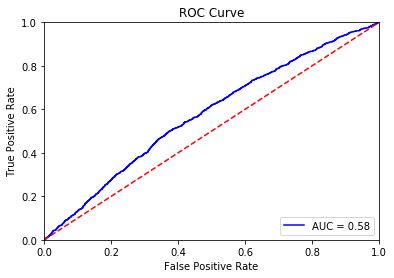

In [187]:
fpr, tpr, threshold = roc_curve(y_test, y_preds[:,1])
roc_auc = auc(fpr, tpr)

plt.title('ROC Curve');
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc);
plt.legend(loc = 'lower right');
plt.plot([0, 1], [0, 1],'r--');
plt.xlim([0, 1]);
plt.ylim([0, 1]);
plt.ylabel('True Positive Rate');
plt.xlabel('False Positive Rate');

In [87]:
clf = RandomForestClassifier()

# parameters to gridsearch
criterion = ['gini', 'entropy']
n_estimators = [2,4,6,8, 10]
max_features = ['auto', 'log2', None]
min_samples_split = [2,3,4]

grid = GridSearchCV(estimator=clf, scoring='accuracy', cv=5, param_grid=dict(criterion=criterion, n_estimators=n_estimators,
                                                       max_features=max_features, min_samples_split=min_samples_split))

grid.fit(X,y)

print grid.best_score_
print grid.best_params_

0.525067791542
{'max_features': None, 'min_samples_split': 2, 'criterion': 'entropy', 'n_estimators': 10}


In [101]:
clf = RandomForestClassifier(max_features=None, min_samples_split=2, criterion='entropy',
                            n_estimators=10)

clf.fit(X_train, y_train)

y_preds = clf.predict(X_test)

Confusion matrix, without normalization
[[1133  888]
 [1152 1077]]
Normalized confusion matrix
[[ 0.56  0.44]
 [ 0.52  0.48]]


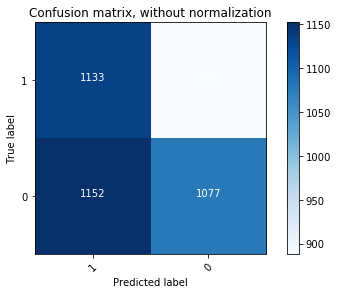

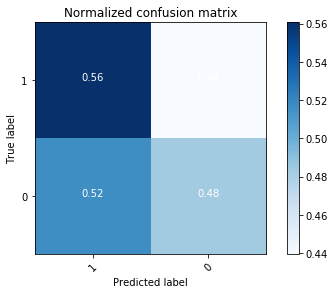

In [102]:
class_names = y.unique()
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Running an SVM Model

In [25]:
from sklearn.grid_search import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, linear_model, datasets
from sklearn.cross_validation import cross_val_score
%matplotlib inline

/Users/elutins/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/elutins/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [26]:
from sklearn.model_selection import train_test_split

### Grid Searching SVM Model for Parameters

In [ ]:
# instantiating the SVM model
clf = svm.SVC()

# setting up parameters for grid searching
gamma_range = 10.**np.arange(-1, 2)
C_range = 10.**np.arange(-1, 3)
kernel_range = ['rbf', 'sigmoid','poly', 'linear']

# Setting Up the Grid Search
grid = GridSearchCV(estimator=clf, cv=5, scoring='roc_auc', param_grid=dict(C=C_range, kernel=kernel_range, 
                                                                           gamma=gamma_range))

# fi
grid.fit(X, y)

print grid.best_score_
print grid.best_params_

# clf = svm.SVC()
# gamma_range = 10.**np.arange(-5, 2)
# C_range = 10.**np.arange(-2, 3)
# kernel_range = ['rbf', 'sigmoid', 'linear', 'poly']
# param_grid = dict(gamma=gamma_range, C=C_range, kernel=kernel_range)
# grid = GridSearchCV(clf, param_grid, cv=10, scoring='accuracy')
# grid.fit(digits_X, digits_y)

In [188]:
# Run this cell when ready

clf = svm.SVC(kernel='rbf', gamma=100.0, C=10.0, probability=True)

clf.fit(X_train, y_train)

y_preds = clf.predict(X_test)

In [189]:
accuracy_score(y_test, y_preds)

0.52447058823529413

### Printing a Confusion Matrix of Above Model

In [44]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [52]:
y.unique()

array([1, 0])

In [118]:
y.value_counts()

0    10256
1     9678
Name: Over hit?, dtype: int64

In [137]:
test_clf = svm.SVC(kernel='rbf', gamma=100.0, C=10.0)
test_clf.fit(X_train, y_train)
test_preds = test_clf.predict(X_test)
test_prob = test_clf.predict_proba(X_test)

AttributeError: predict_proba is not available when  probability=False

In [121]:
y_test.value_counts()

0    3385
1    3194
Name: Over hit?, dtype: int64

In [125]:
pd.DataFrame(test_preds)

,0
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [130]:
a = pd.DataFrame(test_preds)[0].value_counts()

In [134]:
a = pd.DataFrame(test_preds)[0]

In [135]:
a.shape

(6579,)

In [41]:
from sklearn.metrics import confusion_matrix

In [136]:
confusion_matrix(y_test, a)

array([[3385,    0],
       [2045, 1149]])

Confusion matrix, without normalization
[[3385    0]
 [2045 1149]]
Normalized confusion matrix
[[ 1.    0.  ]
 [ 0.64  0.36]]


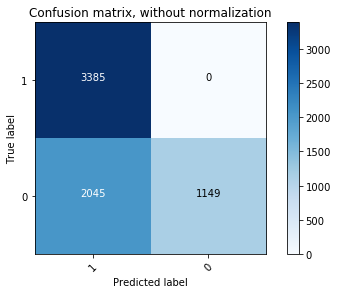

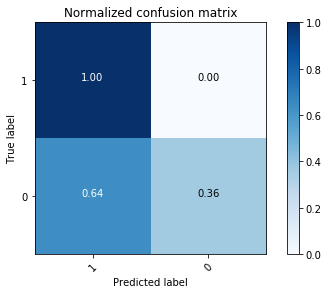

In [122]:
# # import some data to play with
# class_names = y.unique()

# # Split the data into a training set and a test set
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =.33, stratify=y)

# # Run classifier, using a model that is too regularized (C too low) to see
# # the impact on the results
# classifier = svm.SVC(kernel='rbf', gamma=100.0, C=10.0)
# y_pred = classifier.fit(X_train, y_train).predict(X_test)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, test_preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [180]:
# # import some data to play with
# class_names = y.unique()

# # Split the data into a training set and a test set
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =.33, stratify=y)

# # Run classifier, using a model that is too regularized (C too low) to see
# # the impact on the results
# classifier = svm.SVC(kernel='rbf', gamma=100.0, C=10.0)
# y_pred = classifier.fit(X_train, y_train).predict(X_test)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# # Compute confusion matrix
# cnf_matrix = confusion_matrix(y_test, y_pred)
# np.set_printoptions(precision=2)

# # Plot non-normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names,
#                       title='Confusion matrix, without normalization')

# # Plot normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')

# plt.show()

In [ ]:
# Binarize the output
y = label_binarize(y, classes=[0, 1])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = svm.SVC(kernel='rbf', gamma=100.0, C=10.0)

y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
fpr, tpr, threshold = roc_curve(insults_test.Insult, pred_proba[:,1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic');
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc);
plt.legend(loc = 'lower right');
plt.plot([0, 1], [0, 1],'r--');
plt.xlim([0, 1]);
plt.ylim([0, 1]);
plt.ylabel('True Positive Rate');
plt.xlabel('False Positive Rate');

In [191]:
df.to_csv('../CapStone/LetsModelBaby.csv')